# GAN Tutorial

In [11]:
# Basic Imports
%matplotlib inline
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

# Keras Imports
from keras.models import Model
from keras.layers import Input, Reshape
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling1D, Conv1D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, SGD
from keras.callbacks import TensorBoard

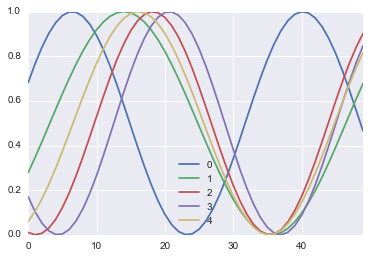

In [5]:
## Simulating Data
def sample_data(n_samples=10000, x_vals=np.arange(0, 5, .1), max_offset=100, mul_range=[1, 2]):
    vectors = []
    for i in range(n_samples):
        offset = np.random.random() * max_offset
        mul = mul_range[0] + np.random.random() * (mul_range[1] - mul_range[0])
        vectors.append(
            np.sin(offset + x_vals * mul) / 2 + .5
        )
    return np.array(vectors)

ax = pd.DataFrame(np.transpose(sample_data(5))).plot()

In [12]:
## Generative Model
def get_generative(G_in, dense_dim=200, out_dim=50, lr=1e-3):
    x = Dense(dense_dim)(G_in)
    x = Activation('tanh')(x)
    G_out = Dense(out_dim, activation='tanh')(x)
    G = Model(G_in, G_out)
    opt = SGD(lr=lr)
    G.compile(loss='binary_crossentropy', optimizer=opt)
    return G, G_out

G_in = Input(shape=[10])
G, G_out = get_generative(G_in)
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               2200      
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                10050     
Total params: 12,250
Trainable params: 12,250
Non-trainable params: 0
_________________________________________________________________


In [13]:
## Descriminative Model
def get_discriminative(D_in, lr=1e-3, drate=.25, n_channels=50, conv_sz=5, leak=.2):
    x = Reshape((-1, 1))(D_in)
    x = Conv1D(n_channels, conv_sz, activation='relu')(x)
    x = Dropout(drate)(x)
    x = Flatten()(x)
    x = Dense(n_channels)(x)
    D_out = Dense(2, activation='sigmoid')(x)
    D = Model(D_in, D_out)
    dopt = Adam(lr=lr)
    D.compile(loss='binary_crossentropy', optimizer=dopt)
    return D, D_out

D_in = Input(shape=[50])
D, D_out = get_discriminative(D_in)
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50)                0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 50, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 46, 50)            300       
_________________________________________________________________
dropout_1 (Dropout)          (None, 46, 50)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2300)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                115050    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 102       
Total para

In [14]:
# Chained Model
def set_trainability(model, trainable=False):
    model.trainable = trainable
    for layer in model.layers:
        layer.trainable = trainable
        
def make_gan(GAN_in, G, D):
    set_trainability(D, False)
    x = G(GAN_in)
    GAN_out = D(x)
    GAN = Model(GAN_in, GAN_out)
    GAN.compile(loss='binary_crossentropy', optimizer=G.optimizer)
    return GAN, GAN_out

GAN_in = Input([10])
GAN, GAN_out = make_gan(GAN_in, G, D)
GAN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 10)                0         
_________________________________________________________________
model_1 (Model)              (None, 50)                12250     
_________________________________________________________________
model_2 (Model)              (None, 2)                 115452    
Total params: 127,702
Trainable params: 12,250
Non-trainable params: 115,452
_________________________________________________________________


In [20]:
# Pre-Training Discriminator
def sample_data_and_gen(G, noise_dim=10, n_samples=10000):
    XT = sample_data(n_samples=n_samples)
    XN_noise = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    XN = G.predict(XN_noise)
    X = np.concatenate((XT, XN))
    y = np.zeros((2*n_samples, 2))
    y[:n_samples, 1] = 1
    y[n_samples:, 0] = 1
    return X, y

def pretrain(G, D, noise_dim=10, n_samples=10000, batch_size=32):
    X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
    set_trainability(D, True)
    D.fit(X, y, epochs=1, batch_size=batch_size)

pretrain(G, D)

Epoch 1/1
20000/20000 [==============================] - 4s - loss: 0.0069     


In [21]:
## Alternating Training
def sample_noise(G, noise_dim=10, n_samples=10000):
    X = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    y = np.zeros((n_samples, 2))
    y[:, 1] = 1
    return X, y

def train(GAN, G, D, epochs=500, n_samples=10000, noise_dim=10, batch_size=32, verbose=True, v_freq=50):
    d_loss = []
    g_loss = []
    e_range = range(epochs)
    if verbose:
        e_range = tqdm(e_range)
    for epoch in e_range:
        X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, True)
        d_loss.append(D.train_on_batch(X, y))
        
        X, y = sample_noise(G, n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, False)
        g_loss.append(GAN.train_on_batch(X, y))
        if verbose and (epoch + 1) % v_freq == 0:
            print("Epoch #{}: Generative Loss: {}, Discriminative Loss: {}".format(epoch + 1, g_loss[-1], d_loss[-1]))
    return d_loss, g_loss

d_loss, g_loss = train(GAN, G, D, verbose=True)

Epoch #50: Generative Loss: 4.08775615692, Discriminative Loss: 0.539668142796
Epoch #100: Generative Loss: 2.27605485916, Discriminative Loss: 0.23991894722
Epoch #150: Generative Loss: 3.59306645393, Discriminative Loss: 0.0879117771983
Epoch #200: Generative Loss: 4.05657243729, Discriminative Loss: 0.0788914337754
Epoch #250: Generative Loss: 4.12712621689, Discriminative Loss: 0.0512797310948
Epoch #300: Generative Loss: 3.91227817535, Discriminative Loss: 0.0434491075575
Epoch #350: Generative Loss: 3.64118051529, Discriminative Loss: 0.0686297640204
Epoch #400: Generative Loss: 3.72025513649, Discriminative Loss: 0.0460736714303
Epoch #450: Generative Loss: 4.65200376511, Discriminative Loss: 0.020164122805
Epoch #500: Generative Loss: 5.11916160583, Discriminative Loss: 0.0235999021679



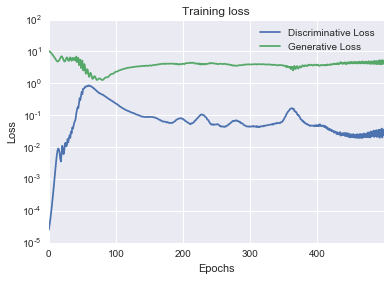

In [22]:
# Plot Curves
ax = pd.DataFrame(
    {
        'Generative Loss': g_loss,
        'Discriminative Loss': d_loss,
    }
).plot(title='Training loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

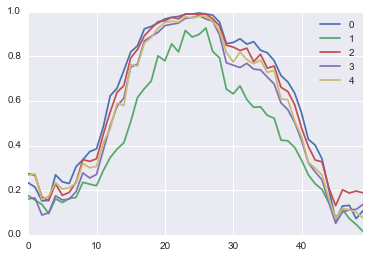

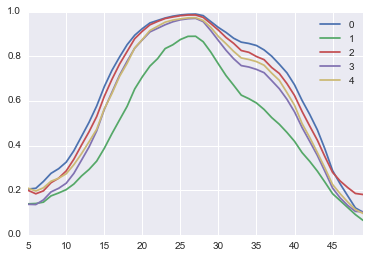

In [27]:
# Visualize
N_VIEWED_SAMPLES = 2
data_and_gen, _ = sample_data_and_gen(G, n_samples=N_VIEWED_SAMPLES)
pd.DataFrame(np.transpose(data_and_gen[N_VIEWED_SAMPLES:])).plot()
pd.DataFrame(np.transpose(data_and_gen[N_VIEWED_SAMPLES:])).rolling(5).mean()[5:].plot()

---